### Imports

In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import random_split
from torch_geometric.data import Data as GeoData
from torch_geometric.loader import DataLoader as GeoLoader
from torch_geometric.nn import GATConv
from tqdm.auto import tqdm



import os
import math
import argparse
import json
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional

import numpy as np
import pandas as pd
import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors



In [2]:
# --------------------
# Config
# --------------------
@dataclass
class Config:
    # Time/grid settings
    freq: str = "15T"                 # sampling interval ("T"=1min, "15T"=15min)
    input_window: int = 30             
    horizon: int = 1                   # forecast t + horizon
    knn: int = 5                       # neighbors per node in similarity graph

    # Prices
    FiT: float = 0.991      # FiT ($/kWh) — OK to keep in config
    include_price_features: bool = True# if True, append [P_buy(t), P_sell] as features per node

    # Training
    epochs: int = 30
    batch_size: int = 1                # one time‑snapshot (all nodes) per batch
    lr: float = 1e-4
    hidden_dim: int = 32
    gat_heads: int = 2
    gat_layers: int = 2
    dropout: float = 0.1
    weight_decay: float = 1e-5

    # Misc
    device: str = "mps" if torch.mps.is_available() else "cpu"
    results_dir: str = "results"


In [ ]:
from pathlib import Path
data_path = input("What is the Path to your dataset on your comuputer?")
data = pd.read_csv(data_path)

In [4]:
data.columns

Index(['timestamp', 'dataid', 'air1', 'air2', 'air3', 'airwindowunit1',
       'aquarium1', 'bathroom1', 'bathroom2', 'bedroom1', 'bedroom2',
       'bedroom3', 'bedroom4', 'bedroom5', 'battery1', 'car1', 'car2',
       'circpump1', 'clotheswasher1', 'clotheswasher_dryg1', 'diningroom1',
       'diningroom2', 'dishwasher1', 'disposal1', 'drye1', 'dryg1', 'freezer1',
       'furnace1', 'furnace2', 'garage1', 'garage2', 'grid', 'heater1',
       'heater2', 'heater3', 'housefan1', 'icemaker1', 'jacuzzi1', 'kitchen1',
       'kitchen2', 'kitchenapp1', 'kitchenapp2', 'lights_plugs1',
       'lights_plugs2', 'lights_plugs3', 'lights_plugs4', 'lights_plugs5',
       'lights_plugs6', 'livingroom1', 'livingroom2', 'microwave1', 'office1',
       'outsidelights_plugs1', 'outsidelights_plugs2', 'oven1', 'oven2',
       'pool1', 'pool2', 'poollight1', 'poolpump1', 'pump1', 'range1',
       'refrigerator1', 'refrigerator2', 'security1', 'sewerpump1', 'shed1',
       'solar', 'solar2', 'sprinkler1',

In [5]:
data.dataid.unique()

array([1642., 4373.,  661., 9922., 8156., 9019., 4767., 3538., 7951.,
       7719., 7536., 5746., 2335., 9278., 8386., 7800., 9160., 2818.,
       3039., 8565., 2361., 6139., 3456., 7901., 4031.])

In [6]:
nan_rows = data[data['dataid'].isna()]
print(nan_rows)

Empty DataFrame
Columns: [timestamp, dataid, air1, air2, air3, airwindowunit1, aquarium1, bathroom1, bathroom2, bedroom1, bedroom2, bedroom3, bedroom4, bedroom5, battery1, car1, car2, circpump1, clotheswasher1, clotheswasher_dryg1, diningroom1, diningroom2, dishwasher1, disposal1, drye1, dryg1, freezer1, furnace1, furnace2, garage1, garage2, grid, heater1, heater2, heater3, housefan1, icemaker1, jacuzzi1, kitchen1, kitchen2, kitchenapp1, kitchenapp2, lights_plugs1, lights_plugs2, lights_plugs3, lights_plugs4, lights_plugs5, lights_plugs6, livingroom1, livingroom2, microwave1, office1, outsidelights_plugs1, outsidelights_plugs2, oven1, oven2, pool1, pool2, poollight1, poolpump1, pump1, range1, refrigerator1, refrigerator2, security1, sewerpump1, shed1, solar, solar2, sprinkler1, sumppump1, utilityroom1, venthood1, waterheater1, waterheater2, wellpump1, winecooler1, leg1v, leg2v, hour, minute, time_sin, time_cos, day_of_week, is_weekend, grid_import, grid_export, generation, power_shifta

In [7]:
data = data.dropna(subset=['dataid'])

In [8]:
data["dataid"] = data["dataid"].astype(int).astype(str).rename('node')
data = data.rename(columns={'dataid':'node'})


In [9]:
df2 = data[['timestamp','node','time_sin', 'time_cos', 'shiftable_loads', 'base_loads', 'demand', 'generation', 'net_load']]
features = ['time_sin', 'time_cos', 'shiftable_loads', 'base_loads', 'demand', 'generation', 'net_load']
df2.head()

,timestamp,node,time_sin,time_cos,shiftable_loads,base_loads,demand,generation,net_load
0,2018-01-01 06:00:00,1642,1.000000,6.123234e-17,0.002,7.454000,0.002,0.005,-0.003
1,2018-01-01 06:15:00,4373,0.997859,-6.540313e-02,0.551,25.314456,0.551,0.015,0.536
2,2018-01-01 06:30:00,661,0.991445,-1.305262e-01,0.235,37.653919,0.235,0.000,0.235
3,2018-01-01 06:45:00,9922,0.980785,-1.950903e-01,0.715,53.216695,0.715,0.000,0.715
4,2018-01-01 07:00:00,8156,0.965926,-2.588190e-01,0.008,7.885107,0.008,0.000,0.008


In [10]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

/var/folders/7j/72bggrrd5q119jndsw6y6dcw0000gn/T/ipykernel_5333/2185136875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['timestamp'] = pd.to_datetime(df2['timestamp'])


In [11]:
df2 = df2.set_index(['timestamp','node']).sort_index()
df2.head()

,,time_sin,time_cos,shiftable_loads,base_loads,demand,generation,net_load
timestamp,node,,,,,,,
2018-01-01 06:00:00,1642,1.000000,6.123234e-17,0.002,7.454000,0.002,0.005,-0.003
2018-01-01 06:15:00,4373,0.997859,-6.540313e-02,0.551,25.314456,0.551,0.015,0.536
2018-01-01 06:30:00,661,0.991445,-1.305262e-01,0.235,37.653919,0.235,0.000,0.235
2018-01-01 06:45:00,9922,0.980785,-1.950903e-01,0.715,53.216695,0.715,0.000,0.715
2018-01-01 07:00:00,8156,0.965926,-2.588190e-01,0.008,7.885107,0.008,0.000,0.008


In [12]:
df2.index

MultiIndex([('2018-01-01 06:00:00', '1642'),
            ('2018-01-01 06:15:00', '4373'),
            ('2018-01-01 06:30:00',  '661'),
            ('2018-01-01 06:45:00', '9922'),
            ('2018-01-01 07:00:00', '8156'),
            ('2018-01-01 07:15:00', '9019'),
            ('2018-01-01 07:30:00', '4767'),
            ('2018-01-01 07:45:00', '3538'),
            ('2018-01-01 08:00:00', '7951'),
            ('2018-01-01 08:15:00', '9922'),
            ...
            ('2019-01-01 03:30:00', '9160'),
            ('2019-01-01 03:45:00', '4373'),
            ('2019-01-01 04:00:00', '7719'),
            ('2019-01-01 04:15:00', '4373'),
            ('2019-01-01 04:30:00', '1642'),
            ('2019-01-01 04:45:00', '7901'),
            ('2019-01-01 05:00:00', '3039'),
            ('2019-01-01 05:15:00', '8386'),
            ('2019-01-01 05:30:00', '9019'),
            ('2019-01-01 05:45:00', '7800')],
           names=['timestamp', 'node'], length=35040)

In [13]:
times = df2.index.get_level_values(0).unique()
nodes = df2.index.get_level_values(1).unique().values


In [14]:
# Make a row for each node at each time step 
full_index = pd.MultiIndex.from_product([times, nodes], names=["time", "node"]) 
df2 = df2.reindex(full_index) 
# df["total_consumption"] = df["total_consumption"].interpolate(method="linear", limit_direction="both")

In [15]:
df2.isna().sum()

time_sin           840960
time_cos           840960
shiftable_loads    840960
base_loads         840960
demand             840960
generation         840960
net_load           840960
dtype: int64

In [16]:
df2 = df2.interpolate().ffill().bfill()

In [17]:
df2.isna().sum().sum()

np.int64(0)

In [18]:
df2.head()

time_sin      time_cos  shiftable_loads  base_loads  \
time                node                                                        
2018-01-01 06:00:00 1642  1.000000  6.123234e-17         0.002000    7.454000   
                    4373  0.999918 -2.515505e-03         0.023115    8.140941   
                    661   0.999835 -5.031010e-03         0.044231    8.827881   
                    9922  0.999753 -7.546515e-03         0.065346    9.514822   
                    8156  0.999671 -1.006202e-02         0.086462   10.201762   

                            demand  generation  net_load  
time                node                                  
2018-01-01 06:00:00 1642  0.002000    0.005000 -0.003000  
                    4373  0.023115    0.005385  0.017731  
                    661   0.044231    0.005769  0.038462  
                    9922  0.065346    0.006154  0.059192  
                    8156  0.086462    0.006538  0.079923

In [19]:
# I am using 15 minutely sampled 6 month data of 10 prosumers. 
idx = pd.IndexSlice
nodes = nodes[0:10]
df = df2.loc[idx['2018-01':'2018-06-30', nodes], :]
times = df.index.get_level_values(0).unique()
nodes = df.index.get_level_values(1).unique().values
df.head()

time_sin      time_cos  shiftable_loads  base_loads  \
time                node                                                        
2018-01-01 06:00:00 1642  1.000000  6.123234e-17         0.002000    7.454000   
                    4373  0.999918 -2.515505e-03         0.023115    8.140941   
                    661   0.999835 -5.031010e-03         0.044231    8.827881   
                    9922  0.999753 -7.546515e-03         0.065346    9.514822   
                    8156  0.999671 -1.006202e-02         0.086462   10.201762   

                            demand  generation  net_load  
time                node                                  
2018-01-01 06:00:00 1642  0.002000    0.005000 -0.003000  
                    4373  0.023115    0.005385  0.017731  
                    661   0.044231    0.005769  0.038462  
                    9922  0.065346    0.006154  0.059192  
                    8156  0.086462    0.006538  0.079923

In [20]:
df.tail()

time_sin  time_cos  shiftable_loads  base_loads  \
time                node                                                    
2018-06-30 23:45:00 9019 -0.083719  0.996055         0.129156   73.396836   
                    4767 -0.081684  0.996255         0.123250   73.781572   
                    3538 -0.079649  0.996456         0.117344   74.166307   
                    7951 -0.077614  0.996656         0.111438   74.551043   
                    7719 -0.075579  0.996857         0.105531   74.935778   

                            demand  generation  net_load  
time                node                                  
2018-06-30 23:45:00 9019  0.129156    0.327375 -0.198219  
                    4767  0.123250    0.291000 -0.167750  
                    3538  0.117344    0.254625 -0.137281  
                    7951  0.111438    0.218250 -0.106813  
                    7719  0.105531    0.181875 -0.076344

In [21]:
stds = df.groupby(level='node', group_keys=False).std()
threshold = 1e-5
small_std_features = stds[stds<threshold]
print(small_std_features)

      time_sin  time_cos  shiftable_loads  base_loads  demand  generation  \
node                                                                        
1642       NaN       NaN              NaN         NaN     NaN         NaN   
3538       NaN       NaN              NaN         NaN     NaN         NaN   
4373       NaN       NaN              NaN         NaN     NaN         NaN   
4767       NaN       NaN              NaN         NaN     NaN         NaN   
661        NaN       NaN              NaN         NaN     NaN         NaN   
7719       NaN       NaN              NaN         NaN     NaN         NaN   
7951       NaN       NaN              NaN         NaN     NaN         NaN   
8156       NaN       NaN              NaN         NaN     NaN         NaN   
9019       NaN       NaN              NaN         NaN     NaN         NaN   
9922       NaN       NaN              NaN         NaN     NaN         NaN   

      net_load  
node            
1642       NaN  
3538       NaN  
4373   

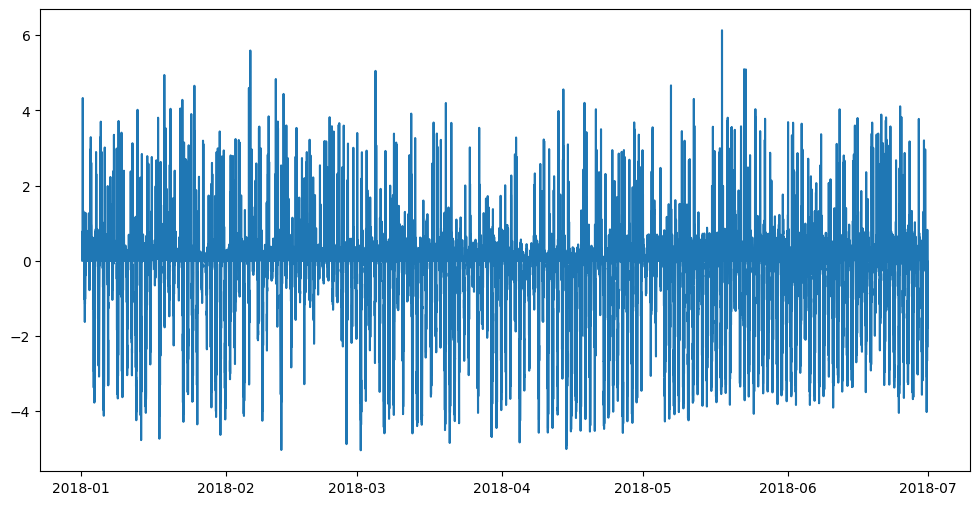

In [22]:
df_node0 = df.loc[(slice(None), nodes[0]), "net_load"]
plt.figure(figsize=(12,6))
plt.plot(df_node0.index.get_level_values(0), df_node0.values)
plt.show()

Build the graph indices

In [23]:
load_mat = df["net_load"].unstack(level=1).values
load_mat.shape # (T, N)

(17352, 10)

In [24]:
# pv_mat = df["generation"].unstack(level=1).values
# feature_vec = np.concatenate([load_mat.T, pv_mat.T], axis=1)
from sklearn.metrics import pairwise_distances
# dist = pairwise_distances(feature_vec, metric="cosine")
dist = pairwise_distances(load_mat.T, metric=lambda u, v: np.mean(np.abs(u + v))) # nodes i and j are close if net_i ~= -net_j

In [25]:
# nodes from your df (these are original IDs, e.g. [1642, 4373, ...])
nodes = df.index.get_level_values(1).unique().values
N = len(nodes)

# Map original node IDs to 0..N-1
node_map = {nid: i for i, nid in enumerate(nodes)}

# Build distance (similarity) matrix first (example: cosine)
# Here I assume you already computed 'dist' between *all* nodes
nbrs = NearestNeighbors(n_neighbors=min(Config.knn+1, N), metric="precomputed")
nbrs.fit(dist)
ind = nbrs.kneighbors(dist, return_distance=False)

edges = set()
for idx in range(N):  # idx is 0..N-1
    for j in ind[idx][1:]:  # skip self
        edges.add((idx, j))
        edges.add((j, idx))

# Convert to torch tensor
edge_index = torch.tensor(list(map(list, zip(*edges))), dtype=torch.long)
print(edge_index.shape)  # should now be [2, E] with values in 0..N-1

torch.Size([2, 72])


In [26]:
edge_index

tensor([[4, 3, 5, 4, 5, 8, 5, 0, 8, 8, 9, 0, 8, 1, 1, 0, 2, 1, 2, 7, 6, 7, 7, 6,
         6, 3, 4, 5, 5, 4, 3, 5, 8, 9, 9, 8, 0, 0, 8, 0, 2, 1, 6, 7, 1, 6, 7, 7,
         6, 7, 4, 3, 5, 3, 8, 8, 5, 8, 9, 0, 2, 9, 0, 1, 2, 7, 6, 6, 7, 6, 6, 7],
        [0, 7, 4, 6, 1, 0, 7, 2, 3, 9, 8, 5, 6, 0, 6, 8, 5, 9, 8, 4, 2, 1, 7, 5,
         8, 0, 5, 0, 6, 8, 6, 3, 2, 1, 7, 5, 1, 7, 8, 4, 7, 5, 1, 0, 8, 4, 3, 9,
         7, 6, 7, 5, 2, 8, 4, 1, 8, 7, 9, 3, 0, 6, 6, 7, 6, 2, 0, 6, 5, 3, 9, 8]])

If the graph was fully connected, there would be 25\times 24=600 edges. Here, I want each node to have 5 (=Config.knn) neighbors. 

In [27]:
FiT = pd.Series(Config.FiT, index=times)
FiT.head()

time
2018-01-01 06:00:00    0.991
2018-01-01 06:15:00    0.991
2018-01-01 06:30:00    0.991
2018-01-01 06:45:00    0.991
2018-01-01 07:00:00    0.991
dtype: float64

In [28]:
# --------------------
# Utility: TOU prices
# --------------------

def generate_tou_price(time_index: pd.DatetimeIndex) -> pd.Series:
    """Example TOU: peak 16:00–21:00 at $0.30/kWh, off‑peak $0.10/kWh. Edit as needed."""
    tou = pd.Series(
        np.where((time_index.hour >= 16) & (time_index.hour < 21), 0.30, 0.10),
        index=time_index
    )
    return tou

ToU = generate_tou_price(time_index=times)
ToU.head()

time
2018-01-01 06:00:00    0.1
2018-01-01 06:15:00    0.1
2018-01-01 06:30:00    0.1
2018-01-01 06:45:00    0.1
2018-01-01 07:00:00    0.1
dtype: float64

Prepare sliding windows and settlement targets

In [29]:
def _settle_once(net: np.ndarray, number_of_nodes: int, edge_index) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Compute P2P flows for a single time step given *unsettled* net = demand - pv.
        Returns (flows, inflow, outflow):
          flows: (N,N) seller->buyer amounts (kWh over interval, here treated as kW for simplicity)
          inflow: per node received energy from peers
          outflow: per node sent energy to peers
        Rule: proportional routing along the static kNN graph using similarity weights.
        """
        N = number_of_nodes
        net = net.copy()
        sellers = np.where(net < 0)[0]
        buyers  = np.where(net > 0)[0]
        if len(sellers) == 0 or len(buyers) == 0:
            return np.zeros((N, N), dtype=np.float32), np.zeros(N, dtype=np.float32), np.zeros(N, dtype=np.float32)

        # Build adjacency weights from edge_index (uniform or degree‑normalized). Here: uniform over out‑neighbors.
        A = np.zeros((N, N), dtype=np.float32)
        src, dst = edge_index.numpy()
        for s, d in zip(src, dst):
            A[s, d] += 1.0
        # Restrict seller rows to only point to buyers
        mask = np.zeros_like(A)
        mask[np.ix_(sellers, buyers)] = 1.0
        A = A * mask
        # Row‑normalize seller rows
        row_sum = A.sum(axis=1, keepdims=True) + 1e-8
        W = A / row_sum

        supply = -net.copy()  # positive supply for sellers
        supply[supply < 0] = 0.0
        demand = net.copy()   # positive demand for buyers
        demand[demand < 0] = 0.0

        # Proposed flows from each seller to buyers (split by W)
        E = (supply[:, None] * W)  # (N,N)

        # Cap each buyer column by its demand via a column scaling factor
        col_sum = E.sum(axis=0)
        scale = np.ones(N, dtype=np.float32)
        nonzero = col_sum > 1e-8
        scale[nonzero] = np.minimum(1.0, demand[nonzero] / col_sum[nonzero])
        E = E * scale[None, :]

        inflow = E.sum(axis=0)
        outflow = E.sum(axis=1)
        return E.astype(np.float32), inflow.astype(np.float32), outflow.astype(np.float32)

In [30]:
rows = []
N = len(nodes)
for t_now in times:
    target_net_load = df.loc[(t_now, slice(None)), "net_load"].values.astype(np.float32)

    # Settlement 
    flows, inflow, outflow = _settle_once(net=target_net_load, number_of_nodes=N, edge_index=edge_index)
    y_settled = target_net_load - inflow + outflow  # per node, kW

    
    # Append rows for each node at this time
    for n_idx, node in enumerate(nodes):
        rows.append({
            "time": t_now,
            "node": node,
            "y_settled": y_settled[n_idx],
            "in_flow": inflow[n_idx],
            "out_flow": outflow[n_idx],
        })
# Convert rows to a DataFrame
settlement_df = pd.DataFrame(rows).set_index(["time", "node"])

# Merge with original df
df = df.merge(settlement_df, left_index=True, right_index=True)


In [31]:
df.head()

time_sin      time_cos  shiftable_loads  base_loads  \
time                node                                                        
2018-01-01 06:00:00 1642  1.000000  6.123234e-17         0.002000    7.454000   
                    4373  0.999918 -2.515505e-03         0.023115    8.140941   
                    661   0.999835 -5.031010e-03         0.044231    8.827881   
                    9922  0.999753 -7.546515e-03         0.065346    9.514822   
                    8156  0.999671 -1.006202e-02         0.086462   10.201762   

                            demand  generation  net_load  y_settled   in_flow  \
time                node                                                        
2018-01-01 06:00:00 1642  0.002000    0.005000 -0.003000   0.000000  0.000000   
                    4373  0.023115    0.005385  0.017731   0.017356  0.000375   
                    661   0.044231    0.005769  0.038462   0.038087  0.000375   
                    9922  0.065346    0.006154  0.059192   0.058817  0.000375   
                    8156  0.086462    0.006538  0.079923   0.079548  0.000375   

                          out_flow  
time                node            
2018-01-01 06:00:00 1642     0.003  
                    4373     0.000  
                    661      0.000  
                    9922     0.000  
                    8156     0.000

In [32]:
df.columns

Index(['time_sin', 'time_cos', 'shiftable_loads', 'base_loads', 'demand',
       'generation', 'net_load', 'y_settled', 'in_flow', 'out_flow'],
      dtype='object')

In [33]:
df = df.drop('base_loads', axis=1)

In [34]:
df_node0 = df.loc[(slice(None), nodes[0]),:]
df_node0 = df_node0.reset_index(level=1, drop=True)
df_node0 = df_node0.loc['2018-01':'2018-06']

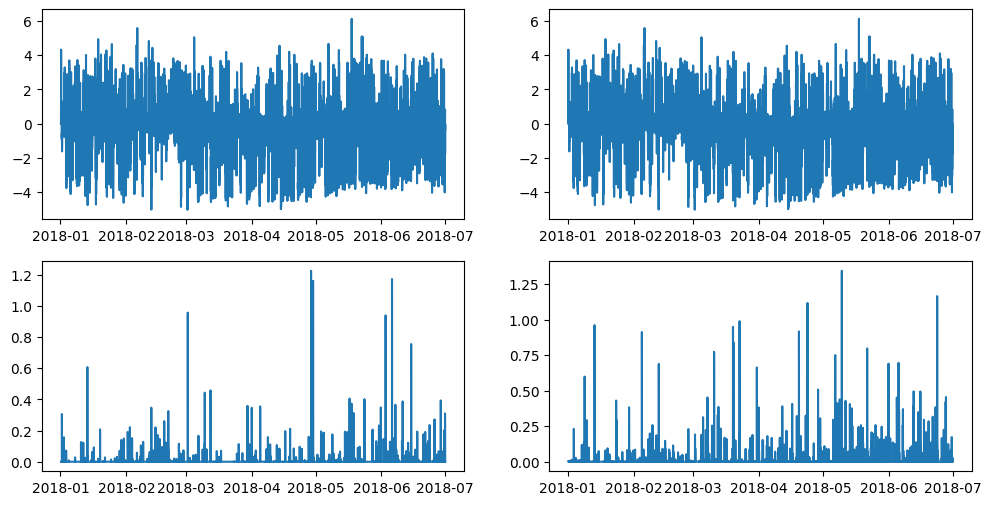

In [35]:
# df_node0 = df.loc[(slice(None), nodes[0]),:]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axes[0,0].plot(df_node0.index, df_node0.net_load, label="net load")
axes[0,1].plot(df_node0.index, df_node0.y_settled, label="y_settled")
axes[1,0].plot(df_node0.index, df_node0.in_flow, label="in_flow")
axes[1,1].plot(df_node0.index, df_node0.out_flow, label="out_flow")
plt.show()

In [36]:
df_train = df['2018-01':'2018-05']
df_val = df['2018-06-01':'2018-06-15']
df_test = df['2018-06-15':]

In [102]:
# save the above datasets for later stages
df_train.to_csv("documents/Train_df.csv", index=True)
df_val.to_csv("documents/Val_df.csv", index=True)
df_test.to_csv("documents/Test_df.csv", index=True)

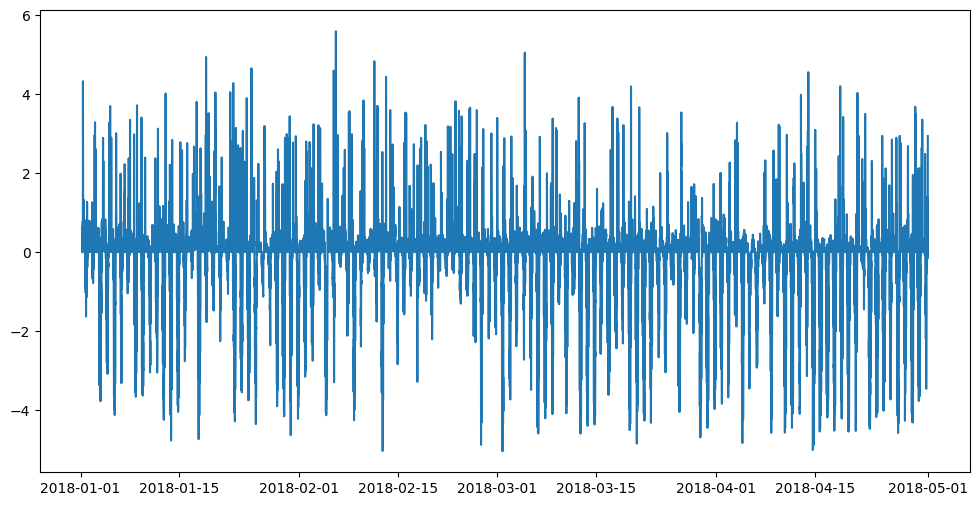

In [37]:
import matplotlib.pyplot as plt 
node0_mask = (df_train.index.get_level_values(1)==nodes[0])
feature_cols = ['time_sin', 'time_cos', 'shiftable_loads', 
                'demand', 'generation', 'net_load', 'y_settled', 'in_flow', 'out_flow']
df_train_node0 = df_train.loc[(slice(None),node0_mask), feature_cols]
df_train_node0.head()
plt.figure(figsize=(12,6))
plt.plot(df_train_node0.index.get_level_values(0), df_train_node0.net_load)
plt.show()

In [38]:
from sklearn.preprocessing import StandardScaler

feature_cols = ['time_sin', 'time_cos', 'shiftable_loads', 
                'demand', 'generation', 'net_load', 'y_settled', 'in_flow', 'out_flow']
scalers = {}

for node in df.index.get_level_values(1).unique():
    node_mask_train = (df_train.index.get_level_values(1) == node)
    scaler = StandardScaler()
    df_train.loc[node_mask_train, feature_cols] = scaler.fit_transform(
        df_train.loc[node_mask_train, feature_cols]
    )
    
    for split in [df_val, df_test]:
        node_mask = (split.index.get_level_values(1) == node)
        split.loc[node_mask, feature_cols] = scaler.transform(
            split.loc[node_mask, feature_cols]
        )
    
    scalers[node] = scaler 

/var/folders/7j/72bggrrd5q119jndsw6y6dcw0000gn/T/ipykernel_5333/604982987.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.23636    0.69019285 0.46373376 ... 0.24428692 0.31359661 2.82557622]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_train.loc[node_mask_train, feature_cols] = scaler.fit_transform(
/var/folders/7j/72bggrrd5q119jndsw6y6dcw0000gn/T/ipykernel_5333/604982987.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.05837405 -0.05837405 -0.05837405 ... -0.05837405 -0.05837405
 -0.05837405]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_train.loc[node_mask_train, feature_cols] = scaler.fit_transform(
/var/folders/7j/72bggrrd5q119jndsw6y6dcw0000gn/T/ipykernel_5333/604982987.py:10: FutureWarning: Setting an it

In [39]:


win = Config.input_window   
H   = Config.horizon       
N = len(nodes)

def window_slicing_data(win, H, N, df): 
    times = df.index.get_level_values(0).unique()
    nodes = df.index.get_level_values(1).unique()


    # Dicts to store sequences
    Xt = {}
    yt = {}

    for t_idx in range(win, len(times) - H):
        t_hist = times[t_idx - win : t_idx]     # history [t-win, ..., t-1]
        t_now  = times[t_idx]                   # input reference time
        t_tar  = times[t_idx + H]               # target time

        # Features for all nodes
        X_list = []
        for node in nodes:
            df_hist = df.loc[(t_hist, node), feature_cols]
            x = torch.tensor(df_hist.values, dtype=torch.float32)  # (win, F)
            X_list.append(x.reshape(-1))  # flatten into (win*F)
        X = torch.stack(X_list, dim=0)  # shape (N, win*F)

        # Targets: trading values at t_tar
        target_df = df.loc[(t_tar, slice(None)), ['net_load', 'in_flow', 'out_flow']]
        y = torch.tensor(target_df.values, dtype=torch.float32)  # (N, 3)

        # Store
        Xt[t_now] = X   # input features
        yt[t_now] = y   # targets

    return Xt, yt

Xt_train, yt_train = window_slicing_data(win, H, N, df_train)
Xt_val, yt_val = window_slicing_data(win, H, N, df_val)
Xt_test, yt_test = window_slicing_data(win, H, N, df_test)


In [78]:
df_train.shape

(114970, 9)

In [79]:
Xt_train

{Timestamp('2018-01-01 13:30:00'): tensor([[ 1.4164,  0.0020, -0.4655,  ...,  0.2381, -0.0584, -0.0766],
         [ 1.4162, -0.0015, -0.4211,  ...,  0.2655, -0.0644, -0.0744],
         [ 1.4161, -0.0051, -0.3800,  ...,  0.2921, -0.0600, -0.0577],
         ...,
         [ 1.4156, -0.0230, -0.1774,  ...,  0.4330, -0.0628, -0.0679],
         [ 1.4155, -0.0265, -0.1382,  ...,  0.4608, -0.0676, -0.0702],
         [ 1.4154, -0.0301, -0.0995,  ...,  0.4914, -0.0852, -0.0745]]),
 Timestamp('2018-01-01 13:45:00'): tensor([[ 1.4135, -0.0869,  0.5103,  ...,  0.9562, -0.0584, -0.0766],
         [ 1.4133, -0.0905,  0.5348,  ...,  0.9782, -0.0644, -0.0744],
         [ 1.4130, -0.0941,  0.5069,  ...,  1.0001, -0.0600, -0.0577],
         ...,
         [ 1.4113, -0.1118,  0.4032,  ...,  1.0897, -0.0628, -0.0679],
         [ 1.4109, -0.1154,  0.3847,  ...,  1.0686, -0.0676, -0.0702],
         [ 1.4106, -0.1189,  0.3716,  ...,  1.0519, -0.0852, -0.0745]]),
 Timestamp('2018-01-01 14:00:00'): tensor([[ 1.4

In [77]:
len(Xt_train.keys())


11466

In [80]:
from pandas import Timestamp
key = Timestamp('2018-01-01 13:30:00')
tensor_shape = Xt_train[key].shape
print(tensor_shape)

torch.Size([10, 270])


In [47]:
import torch
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader   # <- use PyG's DataLoader
from torch_geometric.data import Data as GeoData


class P2PDataset(Dataset):
    def __init__(self, Xt, yt, valid_times, edge_index):
        """
        Xt: dict[time] -> node features (tensor [num_nodes, num_features])
        yt: dict[time] -> labels/targets (tensor [num_nodes] or scalar)
        valid_times: list of timesteps
        edge_index: tensor [2, num_edges], same for all graphs
        """
        self.Xt = Xt
        self.yt = yt
        self.times = valid_times
        self.edge_index = edge_index

    def __len__(self):
        return len(self.times)

    def __getitem__(self, idx):
        t = self.times[idx]

        x = torch.tensor(self.Xt[t], dtype=torch.float)   # node features
        y = torch.tensor(self.yt[t], dtype=torch.float)   # labels/targets

        data = GeoData(x=x, edge_index=self.edge_index, y=y)
        data.time = t   # optional: keep the timestamp

        return data

valid_times_train = list(Xt_train.keys())
dataset_train = P2PDataset(Xt_train, yt_train, valid_times_train, edge_index)


valid_times_val = list(Xt_val.keys())
dataset_val = P2PDataset(Xt_val, yt_val, valid_times_val, edge_index)


valid_times_test = list(Xt_test.keys())
dataset_test = P2PDataset(Xt_test, yt_test, valid_times_test, edge_index)


GAT Model

In [48]:
# --------------------
# Model
#--------------------
class GATEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, heads: int, layers: int, dropout: float):
        super().__init__()
        convs = []
        dims = in_dim
        for li in range(layers):
            conv = GATConv(dims, hidden_dim, heads=heads, dropout=dropout, concat=True)
            convs.append(conv)
            dims = hidden_dim * heads
        self.convs = nn.ModuleList(convs)
        self.out_dim = dims
        self.dropout = dropout

    def forward(self, x, edge_index):
        attn_list = []
        for conv in self.convs:
            x, (ei, alpha) = conv(x, edge_index, return_attention_weights=True)
            attn_list.append((ei, alpha))
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return x, attn_list


class GATMarket(nn.Module):
    def __init__(self, in_dim: int, cfg: Config):
        super().__init__()
        self.encoder = GATEncoder(in_dim, cfg.hidden_dim, cfg.gat_heads, cfg.gat_layers, cfg.dropout)
        self.decoder = nn.Linear(cfg.hidden_dim * cfg.gat_heads, in_dim)  # map embeddings back to input space

    def forward(self, data: GeoData):
        z, attn = self.encoder(data.x, data.edge_index)
        x_hat = self.decoder(z)
        return z, attn, x_hat   
    
input_dim = Config.input_window * (len(feature_cols)) 
model = GATMarket(in_dim=input_dim, cfg=Config)

Train GAT.

In [49]:
def train_epoch(model: nn.Module, loader: GeoLoader, optimizer, device, clip_grad: float = None):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch in tqdm(loader, desc="Train", leave=False):
        batch = batch.to(device)
        optimizer.zero_grad()

        z, attn, x_hat = model(batch)

        # try to reconstruct an informative z in input features dim 
        loss = F.mse_loss(x_hat, batch.x)   # unsupervised embedding learning

        loss.backward()
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        optimizer.step()
        total_loss += loss.item()
        n_batches += 1

    return total_loss / max(n_batches, 1)

In [ ]:

from dataclasses import asdict

@torch.no_grad()
def evaluate(model: nn.Module, loader: GeoLoader, device: torch.device, target_names: List[str] = None):
    model.eval()
    losses = []
    mae_per_target = []
    rmse_per_target = []
    for batch in tqdm(loader, desc="Eval", leave=False):
        batch = batch.to(device)
        z, attn, x_hat = model(batch)

        # MSE loss scalar
        loss = F.mse_loss(x_hat, batch.x)
        losses.append(loss.item())

        # per-feature metrics (mean across nodes + time in batch)
        mae_t = torch.mean(torch.abs(x_hat - batch.x), dim=0)      # shape [n_features]
        rmse_t = torch.sqrt(torch.mean((x_hat - batch.x) ** 2, dim=0))  # shape [n_features]

        mae_per_target.append(mae_t.cpu())
        rmse_per_target.append(rmse_t.cpu())

    # Aggregate across batches
    avg_loss = sum(losses) / max(len(losses), 1)
    mae_per_target = torch.stack(mae_per_target).mean(dim=0) if len(mae_per_target) else torch.zeros(x_hat.size(1))
    rmse_per_target = torch.stack(rmse_per_target).mean(dim=0) if len(rmse_per_target) else torch.zeros(x_hat.size(1))

    # Build dictionary of metrics
    metrics = {
        "mse": avg_loss,
        "mae_per_feature": mae_per_target.numpy(),
        "rmse_per_feature": rmse_per_target.numpy()
    }

    # optionally map target names to features (your feature_cols list)
    if target_names:
        metrics["mae_by_name"] = {name: float(mae_per_target[i]) for i, name in enumerate(target_names)}
        metrics["rmse_by_name"] = {name: float(rmse_per_target[i]) for i, name in enumerate(target_names)}

    return metrics


# -------------------------
# Main training routine
# -------------------------
def train_model(model: nn.Module,
                train_dataset: GeoData,
                val_dataset: GeoData,
                cfg: Config,
                save_path: str = "best_gatmarket.pth",
                target_names: List[str] = None):
    device = torch.device(cfg.device if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = GeoLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
    val_loader = GeoLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False)

    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    best_val_loss = math.inf
    best_epoch = -1

    Train_Loss = []
    Val_Loss = []

    for epoch in range(1, cfg.epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device, clip_grad=5.0)
        Train_Loss.append(train_loss)
        val_metrics = evaluate(model, val_loader, device, target_names=target_names)
        val_loss = val_metrics["mse"]
        Val_Loss.append(val_loss)
        scheduler.step(val_loss)

        tqdm.write(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Val MSE: {val_loss:.6f}")
        if target_names:
            for i, name in enumerate(target_names):
                tqdm.write(f"    Val MAE {name}: {val_metrics['mae_by_name'][name]:.6f}, RMSE {val_metrics['rmse_by_name'][name]:.6f}")

        # save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": val_loss,
                "cfg": asdict(cfg)
            }, save_path)
            tqdm.write(f"  -> Saved best model (epoch {epoch}) to {save_path}")

    tqdm.write(f"Training finished. Best val MSE: {best_val_loss:.6f} at epoch {best_epoch}")
    return save_path, Train_Loss, Val_Loss




In [51]:

target_names = ["Net_Load","Settled_Load"]
cfg = Config()
save_path, Train_Loss, Val_Loss = train_model(model, train_dataset=dataset_train, val_dataset=dataset_val, cfg=cfg , save_path="best_gatmarket.pth", target_names=target_names)

print("Best model saved to:", save_path)

Train:   0%|          | 0/11466 [00:00<?, ?it/s]

/var/folders/7j/72bggrrd5q119jndsw6y6dcw0000gn/T/ipykernel_5333/3313402936.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.Xt[t], dtype=torch.float)   # node features
/var/folders/7j/72bggrrd5q119jndsw6y6dcw0000gn/T/ipykernel_5333/3313402936.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.yt[t], dtype=torch.float)   # labels/targets


Epoch 001 | Train Loss: 0.552130 | Val MSE: 0.579862
    Val MAE Net_Load: 0.119262, RMSE 0.120215
    Val MAE Settled_Load: 0.136898, RMSE 0.137766
  -> Saved best model (epoch 1) to best_gatmarket.pth


Epoch 002 | Train Loss: 0.387734 | Val MSE: 0.497861
    Val MAE Net_Load: 0.111913, RMSE 0.112827
    Val MAE Settled_Load: 0.106919, RMSE 0.107865
  -> Saved best model (epoch 2) to best_gatmarket.pth


Epoch 003 | Train Loss: 0.350148 | Val MSE: 0.466702
    Val MAE Net_Load: 0.110790, RMSE 0.111612
    Val MAE Settled_Load: 0.101984, RMSE 0.102905
  -> Saved best model (epoch 3) to best_gatmarket.pth


Epoch 004 | Train Loss: 0.333541 | Val MSE: 0.446467
    Val MAE Net_Load: 0.104877, RMSE 0.105666
    Val MAE Settled_Load: 0.091290, RMSE 0.092187
  -> Saved best model (epoch 4) to best_gatmarket.pth


Epoch 005 | Train Loss: 0.322995 | Val MSE: 0.430425
    Val MAE Net_Load: 0.106090, RMSE 0.106812
    Val MAE Settled_Load: 0.080963, RMSE 0.081909
  -> Saved best model (epoch 5) to best_gatmarket.pth


Epoch 006 | Train Loss: 0.315745 | Val MSE: 0.421212
    Val MAE Net_Load: 0.100752, RMSE 0.101468
    Val MAE Settled_Load: 0.079944, RMSE 0.080824
  -> Saved best model (epoch 6) to best_gatmarket.pth


Epoch 007 | Train Loss: 0.310179 | Val MSE: 0.414127
    Val MAE Net_Load: 0.093453, RMSE 0.094194
    Val MAE Settled_Load: 0.094476, RMSE 0.095277
  -> Saved best model (epoch 7) to best_gatmarket.pth


Epoch 008 | Train Loss: 0.306413 | Val MSE: 0.408388
    Val MAE Net_Load: 0.083750, RMSE 0.084548
    Val MAE Settled_Load: 0.074751, RMSE 0.075621
  -> Saved best model (epoch 8) to best_gatmarket.pth


Epoch 009 | Train Loss: 0.303284 | Val MSE: 0.403279
    Val MAE Net_Load: 0.092656, RMSE 0.093394
    Val MAE Settled_Load: 0.088330, RMSE 0.089132
  -> Saved best model (epoch 9) to best_gatmarket.pth


Epoch 010 | Train Loss: 0.300905 | Val MSE: 0.400637
    Val MAE Net_Load: 0.091459, RMSE 0.092191
    Val MAE Settled_Load: 0.093466, RMSE 0.094250
  -> Saved best model (epoch 10) to best_gatmarket.pth


Epoch 011 | Train Loss: 0.298075 | Val MSE: 0.394707
    Val MAE Net_Load: 0.084022, RMSE 0.084773
    Val MAE Settled_Load: 0.087559, RMSE 0.088345
  -> Saved best model (epoch 11) to best_gatmarket.pth


Epoch 012 | Train Loss: 0.296336 | Val MSE: 0.390688
    Val MAE Net_Load: 0.081383, RMSE 0.082159
    Val MAE Settled_Load: 0.084728, RMSE 0.085503
  -> Saved best model (epoch 12) to best_gatmarket.pth


Epoch 013 | Train Loss: 0.293833 | Val MSE: 0.386436
    Val MAE Net_Load: 0.078358, RMSE 0.079179
    Val MAE Settled_Load: 0.075855, RMSE 0.076666
  -> Saved best model (epoch 13) to best_gatmarket.pth


Epoch 014 | Train Loss: 0.292468 | Val MSE: 0.384836
    Val MAE Net_Load: 0.103389, RMSE 0.103973
    Val MAE Settled_Load: 0.072769, RMSE 0.073602
  -> Saved best model (epoch 14) to best_gatmarket.pth


Epoch 015 | Train Loss: 0.290928 | Val MSE: 0.382833
    Val MAE Net_Load: 0.073228, RMSE 0.074075
    Val MAE Settled_Load: 0.070411, RMSE 0.071250
  -> Saved best model (epoch 15) to best_gatmarket.pth


Epoch 016 | Train Loss: 0.289625 | Val MSE: 0.380683
    Val MAE Net_Load: 0.074973, RMSE 0.075790
    Val MAE Settled_Load: 0.071252, RMSE 0.072103
  -> Saved best model (epoch 16) to best_gatmarket.pth


Epoch 017 | Train Loss: 0.288495 | Val MSE: 0.379092
    Val MAE Net_Load: 0.077618, RMSE 0.078390
    Val MAE Settled_Load: 0.065712, RMSE 0.066581
  -> Saved best model (epoch 17) to best_gatmarket.pth


Epoch 018 | Train Loss: 0.287746 | Val MSE: 0.377869
    Val MAE Net_Load: 0.076891, RMSE 0.077637
    Val MAE Settled_Load: 0.074703, RMSE 0.075495
  -> Saved best model (epoch 18) to best_gatmarket.pth


Epoch 019 | Train Loss: 0.286199 | Val MSE: 0.376860
    Val MAE Net_Load: 0.076062, RMSE 0.076807
    Val MAE Settled_Load: 0.072206, RMSE 0.073005
  -> Saved best model (epoch 19) to best_gatmarket.pth


Epoch 020 | Train Loss: 0.285489 | Val MSE: 0.373779
    Val MAE Net_Load: 0.089635, RMSE 0.090336
    Val MAE Settled_Load: 0.066194, RMSE 0.067039
  -> Saved best model (epoch 20) to best_gatmarket.pth


Epoch 021 | Train Loss: 0.284759 | Val MSE: 0.371606
    Val MAE Net_Load: 0.075090, RMSE 0.075862
    Val MAE Settled_Load: 0.075042, RMSE 0.075835
  -> Saved best model (epoch 21) to best_gatmarket.pth


Epoch 022 | Train Loss: 0.283958 | Val MSE: 0.372913
    Val MAE Net_Load: 0.074877, RMSE 0.075652
    Val MAE Settled_Load: 0.079164, RMSE 0.079960


Epoch 023 | Train Loss: 0.283599 | Val MSE: 0.373773
    Val MAE Net_Load: 0.104672, RMSE 0.105254
    Val MAE Settled_Load: 0.066163, RMSE 0.066995


Epoch 024 | Train Loss: 0.283168 | Val MSE: 0.371655
    Val MAE Net_Load: 0.068321, RMSE 0.069136
    Val MAE Settled_Load: 0.070553, RMSE 0.071367


Epoch 025 | Train Loss: 0.282552 | Val MSE: 0.370209
    Val MAE Net_Load: 0.093438, RMSE 0.094027
    Val MAE Settled_Load: 0.083995, RMSE 0.084721
  -> Saved best model (epoch 25) to best_gatmarket.pth


Epoch 026 | Train Loss: 0.282020 | Val MSE: 0.369904
    Val MAE Net_Load: 0.082765, RMSE 0.083454
    Val MAE Settled_Load: 0.071580, RMSE 0.072396
  -> Saved best model (epoch 26) to best_gatmarket.pth


Epoch 027 | Train Loss: 0.281418 | Val MSE: 0.368887
    Val MAE Net_Load: 0.072794, RMSE 0.073531
    Val MAE Settled_Load: 0.070230, RMSE 0.071017
  -> Saved best model (epoch 27) to best_gatmarket.pth


Epoch 028 | Train Loss: 0.281200 | Val MSE: 0.368720
    Val MAE Net_Load: 0.093449, RMSE 0.094106
    Val MAE Settled_Load: 0.077580, RMSE 0.078331
  -> Saved best model (epoch 28) to best_gatmarket.pth


Epoch 029 | Train Loss: 0.280409 | Val MSE: 0.366826
    Val MAE Net_Load: 0.080286, RMSE 0.080981
    Val MAE Settled_Load: 0.065040, RMSE 0.065867
  -> Saved best model (epoch 29) to best_gatmarket.pth


Epoch 030 | Train Loss: 0.280362 | Val MSE: 0.366661
    Val MAE Net_Load: 0.089445, RMSE 0.090078
    Val MAE Settled_Load: 0.080171, RMSE 0.080970
  -> Saved best model (epoch 30) to best_gatmarket.pth
Training finished. Best val MSE: 0.366661 at epoch 30
Best model saved to: best_gatmarket.pth


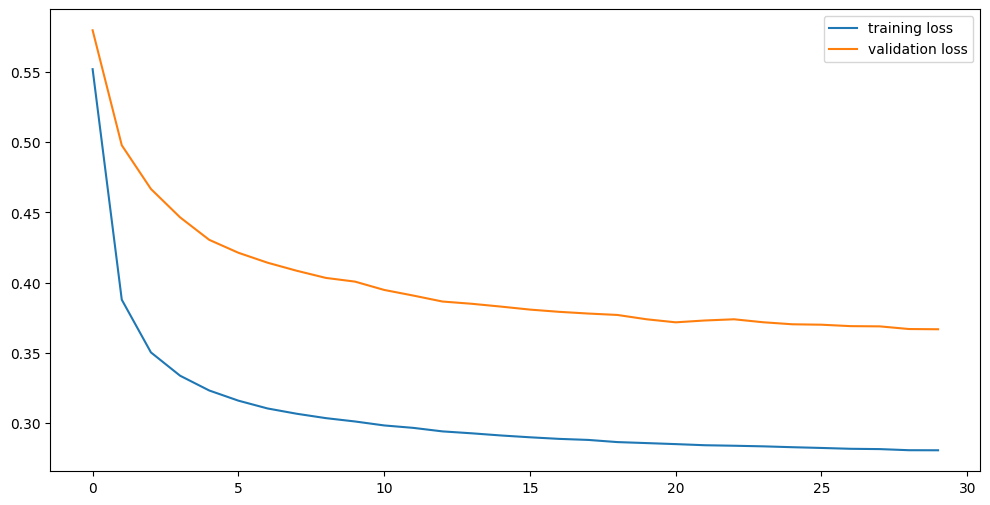

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(Train_Loss, label='training loss')
plt.plot(Val_Loss, label='validation loss')
plt.legend()
plt.show()

Test the GAT model.

In [55]:
@torch.no_grad()
def test(model: nn.Module, loader: GeoLoader, device: torch.device, target_names: List[str] = None,
             collect_embeddings: bool = True, collect_attn: bool = False):
    model.eval()
    model.to(device)
    losses = []
    mae_per_target = []
    rmse_per_target = []

    all_embeddings = []   # to store z
    all_attn = []         # to store attention weights if needed
    all_inputs = []       # original X
    all_recon = []        # reconstructed X_hat

    for batch in tqdm(loader, desc="Eval", leave=False):
        batch = batch.to(device)
        z, attn_list, x_hat = model(batch)

        # Reconstruction loss
        loss = F.mse_loss(x_hat, batch.x)
        losses.append(loss.item())

        # per-feature metrics
        mae_t = torch.mean(torch.abs(x_hat - batch.x), dim=0)
        rmse_t = torch.sqrt(torch.mean((x_hat - batch.x) ** 2, dim=0))

        mae_per_target.append(mae_t.cpu())
        rmse_per_target.append(rmse_t.cpu())

        # Collect extras
        if collect_embeddings:
            all_embeddings.append(z.cpu())
        if collect_attn:
            all_attn.append(attn_list)
        all_inputs.append(batch.x.cpu())
        all_recon.append(x_hat.cpu())

    # Aggregate metrics
    avg_loss = sum(losses) / max(len(losses), 1)
    mae_per_target = torch.stack(mae_per_target).mean(dim=0) if len(mae_per_target) else torch.zeros(x_hat.size(1))
    rmse_per_target = torch.stack(rmse_per_target).mean(dim=0) if len(rmse_per_target) else torch.zeros(x_hat.size(1))

    metrics = {
        "mse": avg_loss,
        "mae_per_feature": mae_per_target.numpy(),
        "rmse_per_feature": rmse_per_target.numpy()
    }

    if target_names:
        metrics["mae_by_name"] = {name: float(mae_per_target[i]) for i, name in enumerate(target_names)}
        metrics["rmse_by_name"] = {name: float(rmse_per_target[i]) for i, name in enumerate(target_names)}

    # Concatenate stored tensors for easy analysis
    results = {
        "metrics": metrics,
        "embeddings": torch.cat(all_embeddings, dim=0) if collect_embeddings else None,
        "attentions": all_attn if collect_attn else None,
        "inputs": torch.cat(all_inputs, dim=0),
        "reconstructed": torch.cat(all_recon, dim=0),
    }

    return results

In [56]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
test_loader = GeoLoader(dataset_test, batch_size=cfg.batch_size, shuffle=False)
results = test(model, test_loader, device, "best_gatmarket.pth")

Eval:   0%|          | 0/1505 [00:00<?, ?it/s]/var/folders/7j/72bggrrd5q119jndsw6y6dcw0000gn/T/ipykernel_5333/3313402936.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.Xt[t], dtype=torch.float)   # node features
/var/folders/7j/72bggrrd5q119jndsw6y6dcw0000gn/T/ipykernel_5333/3313402936.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.yt[t], dtype=torch.float)   # labels/targets


In [ ]:
x_hat = results["reconstructed"]
x_hat.shape

torch.Size([15050, 270])

In [81]:
x_true = results["inputs"]
x_true.shape

torch.Size([15050, 270])

In [87]:
TN, Fw = x_hat.shape  
N = 10
T = TN // N
w = Config.input_window
F = Fw // w
x_hat_reshaped = x_hat.reshape(T, N, w, F)
x_true_reshaped = x_true.reshape(T, N, w, F)

x_hat_inv = np.zeros_like(x_hat_reshaped)
x_true_inv = np.zeros_like(x_true_reshaped)

for i, node in enumerate(nodes):
    scaler = scalers[node]
    for t in range(w):
        x_hat_inv[:, i, t, :] = scaler.inverse_transform(x_hat_reshaped[:, i, t, :])
        x_true_inv[:, i, t, :] = scaler.inverse_transform(x_true_reshaped[:, i, t, :])

In [88]:
x_hat_inv.shape

(1505, 10, 30, 9)

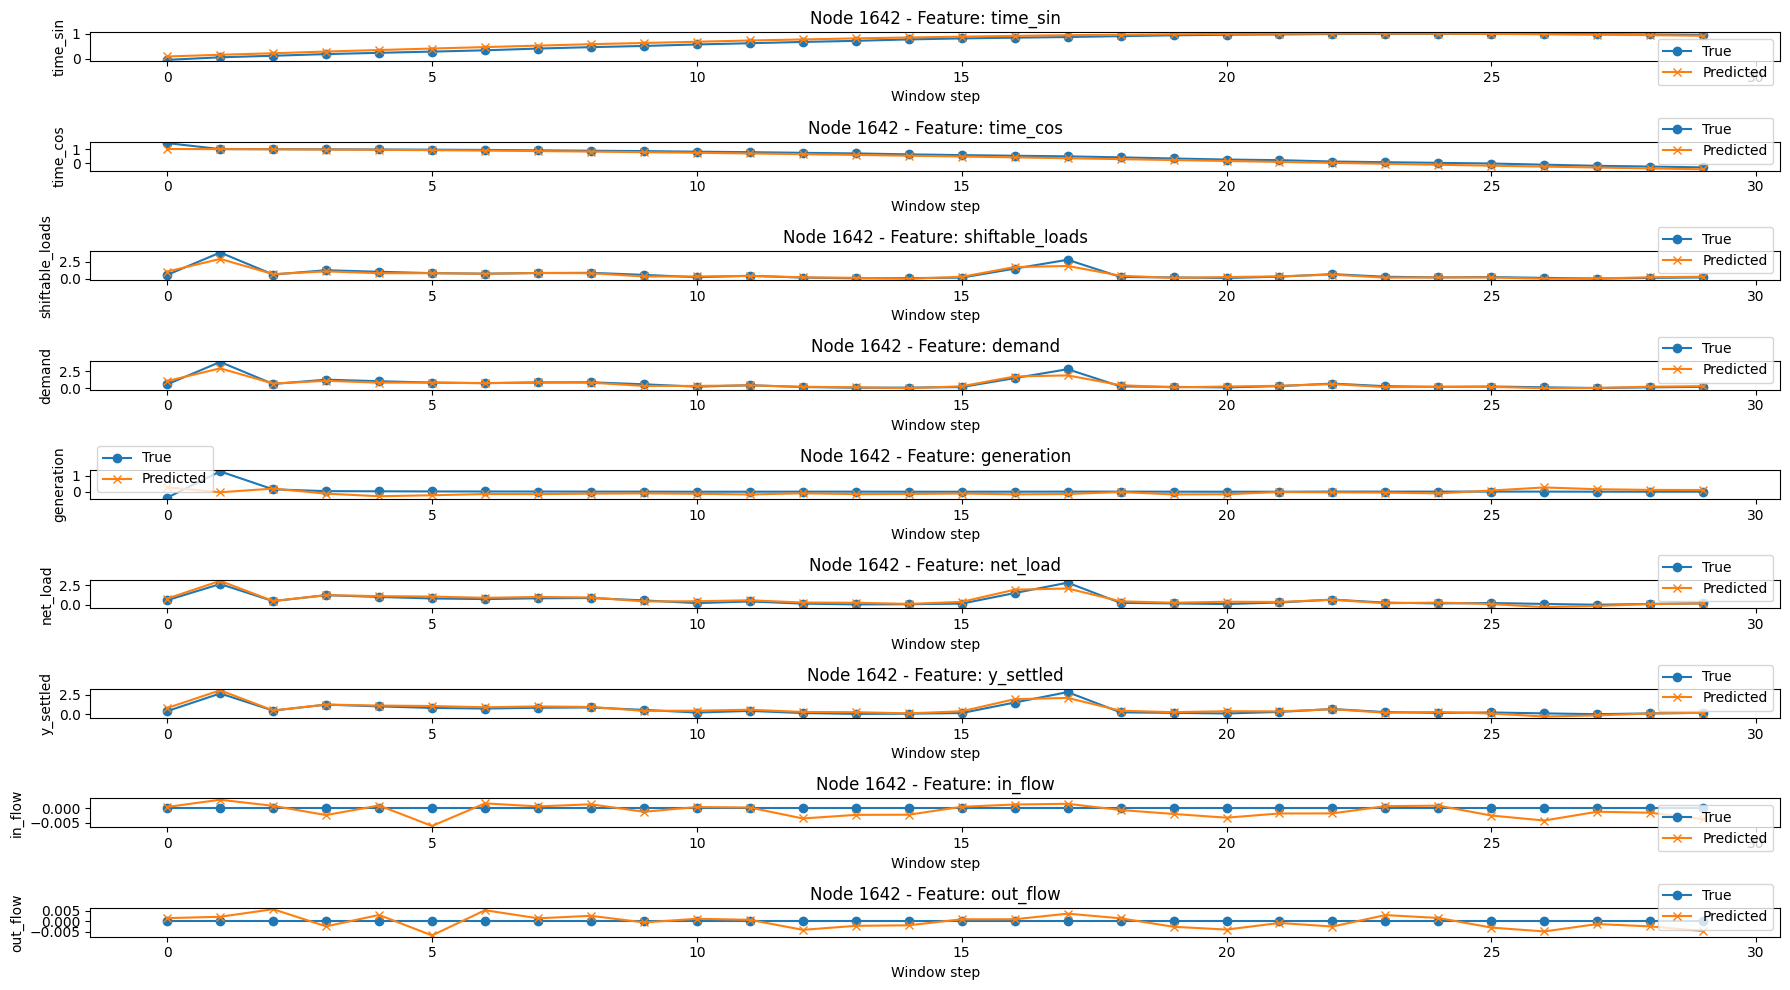

In [89]:
# how well the GAT reconstructs the features.
T, N, w, F = x_true_inv.shape
feature_names = feature_cols  # ['time_sin', 'time_cos', 'shiftable_loads', 'demand', 'generation', 'net_load', 'y_settled', 'in_flow', 'out_flow']

# Example: plot reconstruction for one node over the first few windows
node_idx = 0  # first node
time_idx = 0  # first window in time
plt.figure(figsize=(18, 10))

for f in range(F):
    plt.subplot(F, 1, f+1)
    plt.plot(range(w), x_true_inv[time_idx, node_idx, :, f], label='True', marker='o')
    plt.plot(range(w), x_hat_inv[time_idx, node_idx, :, f], label='Predicted', marker='x')
    plt.title(f'Node {nodes[node_idx]} - Feature: {feature_names[f]}')
    plt.ylabel(feature_names[f])
    plt.xlabel('Window step')
    plt.legend()

plt.tight_layout()
plt.show()

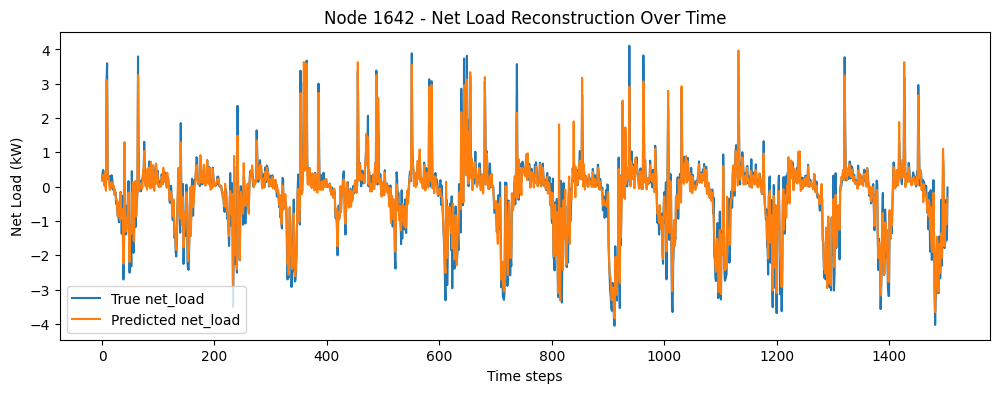

In [99]:
# Single node, entire test set for one feature
feature_idx = feature_names.index('net_load')
node_idx = 0
plt.figure(figsize=(12, 4))
plt.plot(np.arange(T), x_true_inv[:, node_idx, -1, feature_idx], label='True net_load')
plt.plot(np.arange(T), x_hat_inv[:, node_idx, -1, feature_idx], label='Predicted net_load')
plt.title(f'Node {nodes[node_idx]} - Net Load Reconstruction Over Time')
plt.xlabel('Time steps')
plt.ylabel('Net Load (kW)')
plt.legend()
plt.show()

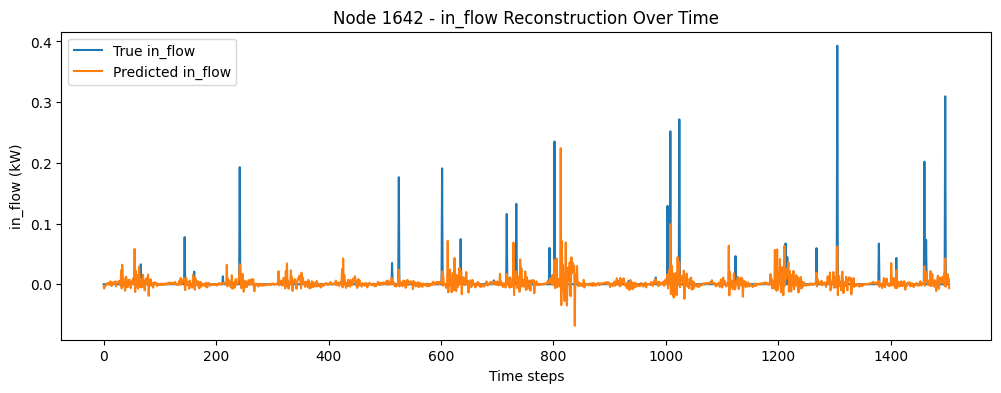

In [100]:
# Single node, entire test set for one feature
feature_idx = feature_names.index('in_flow')
node_idx = 0
plt.figure(figsize=(12, 4))
plt.plot(np.arange(T), x_true_inv[:, node_idx, -1, feature_idx], label='True in_flow')
plt.plot(np.arange(T), x_hat_inv[:, node_idx, -1, feature_idx], label='Predicted in_flow')
plt.title(f'Node {nodes[node_idx]} - in_flow Reconstruction Over Time')
plt.xlabel('Time steps')
plt.ylabel('in_flow (kW)')
plt.legend()
plt.show()

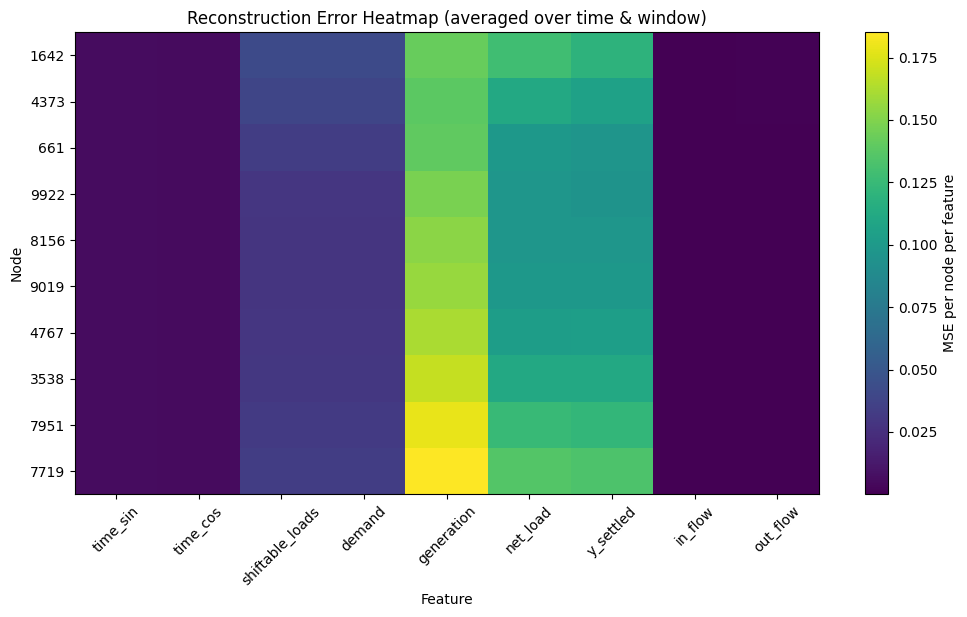

In [93]:
# Heatmap of reconstruction error 
# Node vs Feature (average over time and window):
errors_nf = np.mean((x_true_inv - x_hat_inv)**2, axis=(0,2))  # average over T and w -> shape (N, F)

plt.figure(figsize=(12,6))
plt.imshow(errors_nf, aspect='auto', cmap='viridis')
plt.colorbar(label='MSE per node per feature')
plt.xticks(ticks=np.arange(F), labels=feature_names, rotation=45)
plt.yticks(ticks=np.arange(N), labels=nodes)
plt.xlabel('Feature')
plt.ylabel('Node')
plt.title('Reconstruction Error Heatmap (averaged over time & window)')
plt.show()

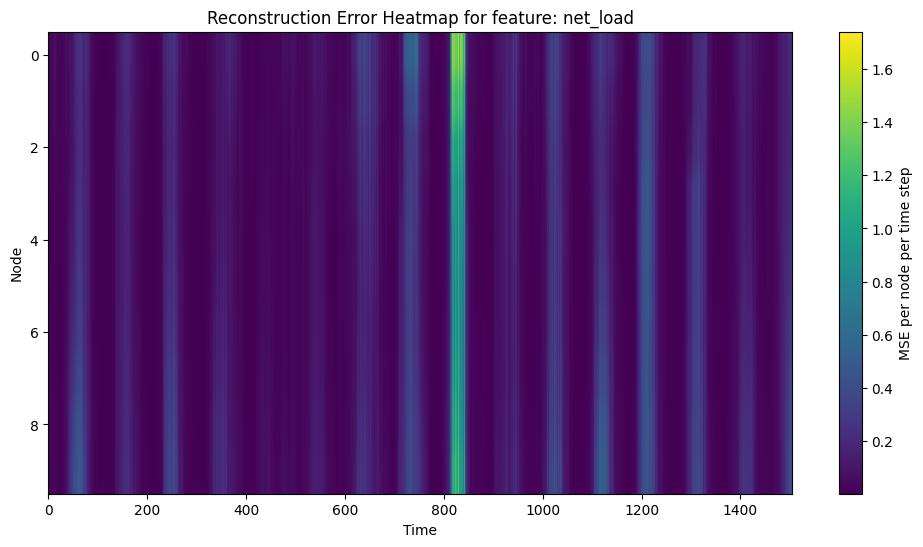

In [94]:
# Heatmap of reconstruction error 
# Node vs Time for a single feature:
feature_idx = feature_names.index('net_load')
errors_nt = np.mean((x_true_inv[:,:,:,feature_idx] - x_hat_inv[:,:,:,feature_idx])**2, axis=2)  # average over window
plt.figure(figsize=(12,6))
plt.imshow(errors_nt.T, aspect='auto', cmap='viridis')
plt.colorbar(label='MSE per node per time step')
plt.xlabel('Time')
plt.ylabel('Node')
plt.title(f'Reconstruction Error Heatmap for feature: {feature_names[feature_idx]}')
plt.show()

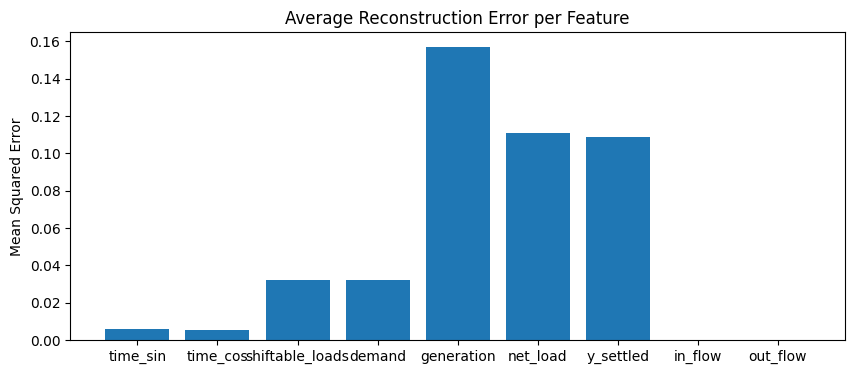

array([0.00614566, 0.0054452 , 0.03245693, 0.03245693, 0.15712056,
       0.11070759, 0.10854081, 0.00032862, 0.00034082], dtype=float32)

In [96]:
# Average reconstruction error per feature
mean_errors = np.mean((x_true_inv - x_hat_inv)**2, axis=(0,1,2))
plt.figure(figsize=(10,4))
plt.bar(feature_names, mean_errors)
plt.ylabel('Mean Squared Error')
plt.title('Average Reconstruction Error per Feature')
plt.show()
mean_errors

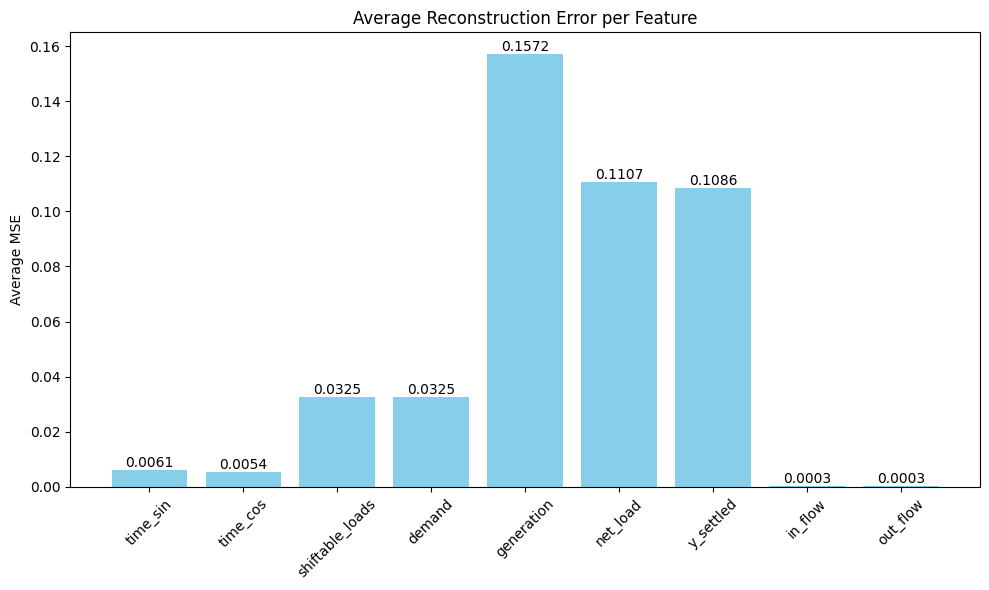

In [97]:
# errors_nf: shape (N, F) -> average over nodes to get feature-level error
avg_error_per_feature = errors_nf.mean(axis=0)  # shape (F,)

plt.figure(figsize=(10,6))
bars = plt.bar(feature_names, avg_error_per_feature, color='skyblue')
plt.ylabel('Average MSE')
plt.title('Average Reconstruction Error per Feature')
plt.xticks(rotation=45)

# Annotate values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [98]:
torch.save(results, "gat_results.pt")

# Loading would be ...
# results = torch.load("gat_results.pt")
# embeddings = results["embeddings"]        # tensor
# attentions = results["attentions"]        # list of attention weights
# inputs = results["inputs"]                # tensor
# reconstructed = results["reconstructed"]  # tensor
# metrics = results["metrics"]              # dict